# PointNet Implementation
## for Semantic Segmentation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm
import time as t
import scipy.constants as spc
import matplotlib.ticker as ticker

import sys
sys.path.append('/home/russbate/MLPionCollaboration/LCStudies/')
from util import resolution_util as ru
from util import plot_util as pu
from util import deep_set_util as dsu

plotpath = '/home/russbate/MLPionCollaboration/LCStudies/segmentation/Plots/October/'

## Declare GPUs and Import TensorFlow

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "4"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_GPU_ALLOCATOR']='cuda_malloc_async'

import tensorflow as tf
from tensorflow.python.client import device_lib

# def get_available_gpus():
#     local_device_protos = device_lib.list_local_devices()
#     return [x.name for x in local_device_protos if x.device_type == 'GPU']

# get_available_gpus()

## Load Models for PointNet
 - [ ] Add working models as bench marks into python scrips and import below

In [3]:
from segmentation import PointNet_models

## Load Data
### X = [Energy, Eta, Phi, rPerp]
### Y = [EM Energy, non EM Energy]

In [4]:
t0 = t.time()
Xraw = np.load('/data/atlas/rbate/Rho_X_4_files.npy', mmap_mode='r')[:,:,:]
Yraw = np.load('/data/atlas/rbate/Rho_Y_4_files.npy', mmap_mode='r')[:,:,:]
print(Xraw.shape)
print(Yraw.shape)

X = np.lib.format.open_memmap('/data/atlas/rbate/XR_notebook.npy',
                             mode='w+', dtype=np.float64, shape=(Xraw.shape[0], Xraw.shape[1], Xraw.shape[2]))

Y = np.lib.format.open_memmap('/data/atlas/rbate/YR_notebook.npy',
                             mode='w+', dtype=np.float64, shape=(Yraw.shape[0], Yraw.shape[1], Yraw.shape[2]))
np.copyto(dst=Y, src=Yraw[:,:,:], casting='same_kind', where=True)
t1 = t.time()

Energy_EM = np.ndarray.copy(Yraw[:,:,0])
Energy_nonEM = np.ndarray.copy(Yraw[:,:,1])
nz_mask = (Energy_EM + Energy_nonEM) != 0

print(np.shape(nz_mask))
print(np.count_nonzero(nz_mask))

# Make sure that non-zero elements are copied as zeros due to mis-match
np.copyto(dst=X, src=Xraw, casting='same_kind', where=True)
X[np.invert(nz_mask),:] = 0

print('Time to load memory mapped data: '+str(t1-t0)+' (s)')

(2550, 1078, 4)
(2550, 1078, 2)
(2550, 1078)
527667
Time to load memory mapped data: 0.0722811222076416 (s)


## Create Categorization Labels
Still don't know what to do with the mismatch between truth and reported cells

In [5]:
EM = np.full(nz_mask.shape, np.nan)
nonEM = np.full(nz_mask.shape, np.nan)
target_ratio = np.full((nz_mask.shape), np.nan)

EM[nz_mask] = np.ndarray.copy(Yraw[nz_mask,0])
nonEM[nz_mask] = np.ndarray.copy(Yraw[nz_mask,1])

target_labels = np.full((nz_mask.shape[0],nz_mask.shape[1],3), 0)
target_ratio[nz_mask] = EM[nz_mask] / (EM[nz_mask] + nonEM[nz_mask])

em_mask = target_ratio > .8
nonem_mask = target_ratio < .2
mix_mask = np.invert(np.logical_or(em_mask, nonem_mask))

target_labels[em_mask,0] = 1
target_labels[mix_mask,1] = 1
target_labels[nonem_mask,2] = 1

print('Number EM: '+str(np.count_nonzero(em_mask)))
print('Number NON-EM: '+str(np.count_nonzero(nonem_mask)))
print('Number MIX: '+str(np.count_nonzero(mix_mask)))

# change the pointer for Y to the target labels
Y = target_labels

Number EM: 389638
Number NON-EM: 18871
Number MIX: 2340391


#### Troubleshooting step:
 - [x] Make sure that target ratio and inputs have no nan values
 - [x] make sure that the X array is using the nz_mask so there are no mis-matches
   - This seems to be the problem, the mis-matches between values were yielding nans in the training!

## Point Normalization
 - [x] Convert to x,y,z
 - [x] Investigate Inputs (Rho_Pre-processing.ipynb)
 - [ ] Speed up the normalization process!

In [6]:
print(X[nz_mask, :3].shape)

t0 = t.time()
X[:,:,1:4] = dsu.to_xyz(np.ndarray.copy(Xraw[:,:,1:4]), nz_mask)
t1 = t.time()

## ENERGY ##
log_E_mask = Xraw[:,:,0] > 0
X[log_E_mask,0] = np.log(np.ndarray.copy(Xraw[log_E_mask,0]))

## X ##
X[:,:,1] = X[:,:,1]/3000

## Y ##
X[:,:,2] = X[:,:,2]/1000

## Z ##
X[:,:,3] = X[:,:,3]/1000
t2 = t.time()

print('Time to convert to xyz: '+str(t1-t0)+' (s)')
print('Time to normalize: '+str(t2-t1)+' (s)')
print('Total time: '+str(t2-t0)+' (s)')
print('Target shape: '+str(Y.shape))
print('Input shape: '+str(X.shape))

(527667, 3)
Time to convert to xyz: 0.16160106658935547 (s)
Time to normalize: 0.09522557258605957 (s)
Total time: 0.25682663917541504 (s)
Target shape: (2550, 1078, 3)
Input shape: (2550, 1078, 4)


### More Data Pre-Processing
Working on solution for points of varying input, this should be taken care of with the max pooling layer

In [7]:
NUM_POINTS = X.shape[1]
NUM_CLASSES = 3

## Build Model

## Model with NxK Outputs

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def conv_block(x, filters: int, name: str):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid", name=f"{name}_conv")(x)
    x = layers.BatchNormalization(momentum=0.0, name=f"{name}_batch_norm")(x)
    return layers.Activation("relu", name=f"{name}_relu")(x)

def mlp_block(x: tf.Tensor, size: int, name: str):
    x = layers.Dense(size, name=f"{name}_dense")(x)
    x = layers.BatchNormalization(momentum=0.0, name=f"{name}_batch_norm")(x)
    return layers.Activation("relu", name=f"{name}_relu")(x)

class OrthogonalRegularizer(keras.regularizers.Regularizer):
    """Reference: https://keras.io/examples/vision/pointnet/#build-a-model"""

    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.identity = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.identity))

    def get_config(self):
        config = super(TransformerEncoder, self).get_config()
        config.update({"num_features": self.num_features, "l2reg_strength": self.l2reg})
        return config
    
def Tnet(inputs, num_features: int, name: str):
    x = conv_block(inputs, filters=32, name=f"{name}_1")
    x = conv_block(x, filters=64, name=f"{name}_2")
    x = conv_block(x, filters=512, name=f"{name}_3")
    x = layers.GlobalMaxPooling1D()(x)
    x = mlp_block(x, size=256, name=f"{name}_1_1")
    x = mlp_block(x, size=128, name=f"{name}_2_1")
    return layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=keras.initializers.Constant(np.eye(num_features).flatten()),
        activity_regularizer=OrthogonalRegularizer(num_features),
        name=f"{name}_final",
    )(x)


def T_block(inputs: tf.Tensor, num_features: int, name: str) -> tf.Tensor:
    transformed_features = Tnet(inputs, num_features, name=name)
    transformed_features = layers.Reshape((num_features, num_features))(
        transformed_features
    )
    return layers.Dot(axes=(2, 1), name=f"{name}_mm")([inputs, transformed_features])

In [45]:
class keras_PointNet_segmentation:
    
    def __init__(self, num_points=None, num_features=4, num_classes=3) -> keras.Model:
        
        self.num_points = num_points
        self.num_classes = num_classes
        self.num_features = num_features
        self.model = None
        
    def build(self):
        
        input_points = keras.Input(shape=(self.num_points, self.num_features))
        
        # Masking Section
        masked_input = layers.Masking(mask_value=0.0)(input_points)

        # PointNet Classification Network.
        transformed_inputs = T_block(
            masked_input, num_features=self.num_features, name="inf_transf_block"
        )
        
        features_32_1= mlp_block(transformed_inputs, size=64, name="features_32_1")
        features_32_2 = mlp_block(features_32_1, size=64, name="features_32_2")
        
        transformed_features = T_block(
            features_32_2, num_features=64, name="transformed_features"
        )
        
        mlp_64 = mlp_block(transformed_features, size=64, name="mlp_64")
        mlp_128 = mlp_block(mlp_64, size=128, name="mlp_128")
        mlp_1024 = mlp_block(mlp_128, size=1024, name="mlp_1024")
        
        # make sure this is on the correct axis!!!
        global_features = layers.MaxPool1D(pool_size=self.num_points, name="global_features")(
            mlp_1024
        )
        
        # okay tile in order to concatenate, this basically means repeats
        global_features = tf.tile(global_features, [1, self.num_points, 1])

        # SEGMENTATION INPUT TENSOR
        segmentation_input = layers.Concatenate(name="segm_input")(
            [transformed_features, global_features]
        )
        
        ## SEGMENTATION MLP STAGR
        segmentation_1 = mlp_block(segmentation_input, size=512, name="segm_1")
        segmentation_2 = mlp_block(segmentation_1, size=256, name="segm_2")
        segmentation_3 = mlp_block(segmentation_2, size=128, name="segm_3")
        
        
        outputs = layers.Dense(3, activation="softmax", name="segm_tail"
        )(segmentation_3)
        
        self.model = keras.Model(inputs=input_points, outputs=outputs)
        return self.model

In [46]:
russ_model = keras_PointNet_segmentation(num_points=NUM_POINTS, num_classes=NUM_CLASSES, num_features=4).build()
russ_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1078, 4)]    0                                            
__________________________________________________________________________________________________
masking_4 (Masking)             (None, 1078, 4)      0           input_5[0][0]                    
__________________________________________________________________________________________________
inf_transf_block_1_conv (Conv1D (None, 1078, 32)     160         masking_4[0][0]                  
__________________________________________________________________________________________________
inf_transf_block_1_batch_norm ( (None, 1078, 32)     128         inf_transf_block_1_conv[0][0]    
____________________________________________________________________________________________

#### Compile Model

In [47]:
point_loss = keras.losses.CategoricalCrossentropy(
    from_logits=False,
    label_smoothing=0,
    reduction="auto",
    name="categorical_crossentropy",
)

point_optimizer = keras.optimizers.Adam(learning_rate=0.005)

russ_model.compile(loss=point_loss, optimizer=point_optimizer)

## Set up Datasets and Shuffle

In [48]:
train_num, val_num, test_num = dsu.tvt_num(X, tvt=(70,15,15))
print('Number of training samples: '+str(train_num))
print('Number of validation samples: '+str(val_num))
print('Number of test samples: '+str(test_num))

Number of training samples: 1785
Number of validation samples: 382
Number of test samples: 383


### Using TF DataSets

In [49]:
# dataset = tf.data.Dataset.from_tensor_slices((X,Y))

# example_dataset = dataset.as_numpy_iterator()
# element = example_dataset.next()
# Xa, Ya = element

# dat_tr = dataset.skip(val_num+test_num)
# dat_test = dataset.take(test_num+val_num)
# dat_val = dat_test.skip(test_num)
# dat_test = dataset.take(test_num)

# print(dat_tr.cardinality())
# print(dat_test.cardinality())
# print(dat_val.cardinality())

In [50]:
# Nbatches = int(np.ceil(1785/382))
# print(Nbatches)
# batch_size=int(np.floor(1785/Nbatches))
# print(batch_size)

# dat_tr = dat_tr.batch(Nbatches, drop_remainder=True)
# dat_val = dat_val.batch(Nbatches, drop_remainder=True)
# dat_test = dat_test.batch(Nbatches, drop_remainder=True)

### Using numpy arrays

In [51]:
X_train = np.ndarray.copy(X[:train_num,:,:])
Y_train = np.ndarray.copy(Y[:train_num,:,:])

X_val = np.ndarray.copy(X[train_num:train_num+val_num,:,:])
Y_val = np.ndarray.copy(Y[train_num:train_num+val_num,:,:])

X_test = np.ndarray.copy(X[train_num+val_num:,:,:])
Y_test = np.ndarray.copy(Y[train_num+val_num:,:,:])

In [52]:
print(Y_train.shape)
print(X_train.shape)

(1785, 1078, 3)
(1785, 1078, 4)


### Train

In [53]:
# tf.keras.backend.

In [54]:
history_2 = russ_model.fit(x=X_train, y=Y_train,
                           epochs=30,
                           batch_size=100,
                           validation_data=(X_val, Y_val),
                           verbose=1)

Epoch 1/30
18/18 [==============================] - 6s 328ms/step - loss: 30.7370 - val_loss: 49.6009
Epoch 2/30
18/18 [==============================] - 6s 326ms/step - loss: 9.5657 - val_loss: 8.0281
Epoch 3/30
18/18 [==============================] - 6s 326ms/step - loss: 7.8503 - val_loss: 7.6452
Epoch 4/30
18/18 [==============================] - 6s 338ms/step - loss: 7.3104 - val_loss: 7.2468
Epoch 5/30
18/18 [==============================] - 6s 326ms/step - loss: 6.9092 - val_loss: 6.8907
Epoch 6/30
18/18 [==============================] - 6s 325ms/step - loss: 6.9147 - val_loss: 6.8520
Epoch 7/30
18/18 [==============================] - 6s 326ms/step - loss: 6.8217 - val_loss: 6.8404
Epoch 8/30
18/18 [==============================] - 6s 327ms/step - loss: 6.8339 - val_loss: 7.6345
Epoch 9/30
18/18 [==============================] - 6s 324ms/step - loss: 6.7807 - val_loss: 6.6919
Epoch 10/30
18/18 [==============================] - 6s 327ms/step - loss: 6.7393 - val_loss: 6.56

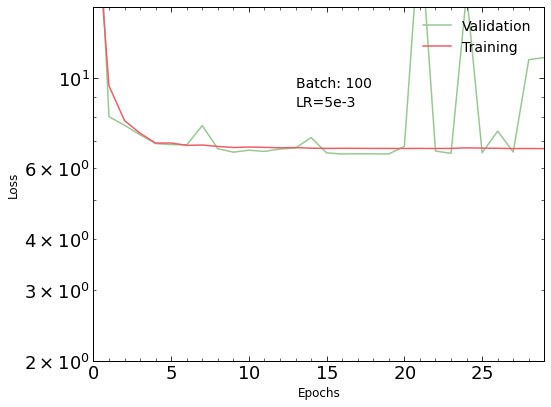

In [57]:
yrange = 15
xrange = len(history_2.history['loss'])-1
# yticks = [y for y in np.arange(2-np.log10(2), yrange, np.log10(2))]
# ylabels = ['{:3.1f}'.format(num) for num in yticks]
# print(ylabels)

fig = plt.figure(figsize=(8,6))
ax = plt.gca()
ax.plot(history_2.history['val_loss'], label="Validation")
ax.plot(history_2.history['loss'], label="Training")
plt.rcParams['font.family'] = 'DejaVu Sans'

# y axis
ax.set_yscale('log')
# ax.set_yticks(yticks)
# ax.set_yticklabels(ylabels, fontsize=12)
ax.set_ylim(2,15)
# ax.yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=10))
# ax.yaxis.set_minor_locator(ticker.LogLocator(base=10, numticks=10))
ax.set_xlim(0,xrange)
ax.set_xlabel('Epochs', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.legend(loc='upper right', ncol=1, prop={"family":'DejaVu Sans', 'size':'14'})
ax.text(13, 8.5, 'LR=5e-3', fontsize=14)
ax.text(13, 9.5, 'Batch: 100', fontsize=14)
plt.tight_layout()
plt.savefig('Plots/November21/PointNet_base_lossCurves_100batch_LR5e-3_2021-11-08.png', format='png')
plt.show()

### Producing plots of predictions versus truth

In [20]:
# print(dat_test.cardinality())

# dat_test.get_single_element()
# # print(tf.rank(dat_test))
# print('Batch size: '+str(int(batch_size)))
# keras.backend.int_shape(dat_test)

In [21]:
preds_1 = russ_model.predict(X_test)

In [22]:
print(np.shape(preds_1))
print(X_test[:10,0,:])
print(Y_test[0,0,:])
print(preds_1[0,0:100,:])

(383, 1078, 3)
[[ 2.26115141e+00  4.48378857e-01  9.72888053e-01 -1.50733932e+00]
 [ 2.93400870e+00  5.68697662e-01  8.90211674e-03  4.36339691e-02]
 [ 4.21150598e+00  5.75559000e-01 -5.31511239e-03  2.05950890e-02]
 [ 3.45566830e+00  6.39201516e-01 -4.35872125e-02  6.84481156e-03]
 [ 2.74772395e+00  5.74348982e-01  3.02939311e-02 -4.23553963e-02]
 [ 3.89586635e+00  5.64766578e-01  1.40259564e-02 -6.16439132e-02]
 [ 4.82986362e+00  1.66644474e-01 -3.88196524e-02 -7.66856166e-02]
 [-6.79471847e-01  8.11210437e-01 -2.82734223e-01 -6.06363399e-01]
 [ 5.84666834e+00  1.85412246e-01 -1.22486447e-02 -3.66685175e-03]
 [ 5.08018102e+00  5.55980380e-01  8.93161422e-02 -1.44726499e-01]]
[1 0 0]
[[0.66507524 0.2656677  0.06925705]
 [0.66925627 0.26337877 0.06736503]
 [0.6406358  0.28645492 0.07290926]
 [0.656623   0.2748919  0.06848506]
 [0.6744961  0.26166263 0.06384122]
 [0.6730578  0.26307607 0.0638661 ]
 [0.70034313 0.2412539  0.05840293]
 [0.68811566 0.25119716 0.06068716]
 [0.70922565 0.233

In [23]:
print(np.sum(preds_1[0,0,:]))

1.0
